<h2>IMPORTAMOS LIBRERÍAS</h2>

In [14]:
import numpy as np
import obspy
import emd
import pandas as pd
from tqdm.notebook import tqdm
import os
import scipy.signal as sg
from concurrent.futures import ThreadPoolExecutor
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
from torchinfo import summary

In [15]:
#Comprobamos que CUDA esté corriendo correctamente en nuestra pc
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version: ", torch.version.cuda)
print("Device Count: ", torch.cuda.device_count())

CUDA Available:  True
CUDA Version:  12.4
Device Count:  1


<h2>PREPROCESAMIENTO<h2>

<h3>LUNA</h3>

In [16]:
# Define el directorio base para los datos.
base_dir = 'data/lunar/training'

# Construye las rutas de manera compatible con Windows y Linux.
catalogy_path = os.path.join(base_dir, 'catalogs', 'apollo12_catalog_GradeA_final.csv')
data_folder = os.path.join(base_dir, 'data', 'S12_GradeA')

# Lee el archivo del catálogo que contiene metadatos sobre el conjunto de datos (por ejemplo, nombres de archivos, etiquetas, etc.).
# catalogy contiene los tiempos de los eventos sísmicos.
# Cada línea de catalogy tiene un nombre de archivo que contiene la velocidad por tiempo, y en qué parte de la secuencia se encuentra el evento sísmico.
catalogy = pd.read_csv(catalogy_path)
indexs = catalogy.index  # Obtiene los índices de las entradas del catálogo

In [17]:
# Función de filtro pasa-banda utilizando el diseño de filtro Butterworth.
# Filtra los datos entre las frecuencias lowc y high.
def butter_bandpass_filter(data: np.array, lowcut: float, highcut: float, fs: float, order: int):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist, la mitad de la tasa de muestreo
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sg.butter(order, [low, high], btype='band', analog=False)  # Diseña el filtro pasa-banda Butterworth
    y = sg.filtfilt(b, a, data)  # Aplica el filtro a los datos usando filtrado cero-fase
    return y

In [18]:
# Índice del catálogo (ejemplo el 7)
idx = 7

# Obtener los detalles del archivo y tiempo de llegada
fileName = catalogy.at[idx, 'filename'] + '.mseed'
arrival_time = catalogy.at[idx, 'time_rel(sec)']

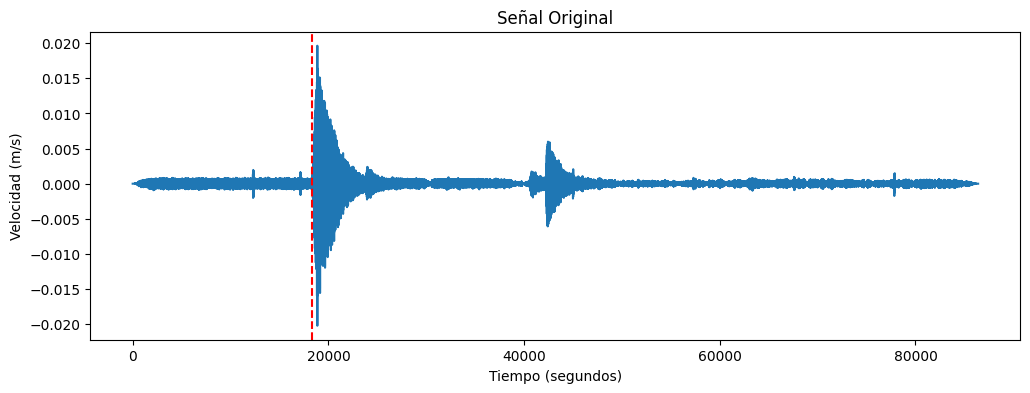

In [19]:
# Lee el archivo de datos sísmicos
stream = obspy.read(os.path.join(data_folder, fileName))
data = stream[0].data*1e6
time = stream[0].times()
fs = stream[0].stats.sampling_rate

# Encuentra el índice del tiempo de llegada en los datos
arrival_idx = np.where(time >= arrival_time)[0][0]


plt.figure(figsize=(12, 4))

# Subplot 1: Señal original
#plt.subplot(3, 2, 1)
plt.plot(time, data, label="Señal original")
plt.title("Señal Original")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Velocidad (m/s)")
plt.axvline(arrival_time, color='r', linestyle='--')

In [20]:
# Filtro pasa banda entre 0.4 y 1 Hz
data_filtered = butter_bandpass_filter(data, 0.4, 1.2, fs, 6)

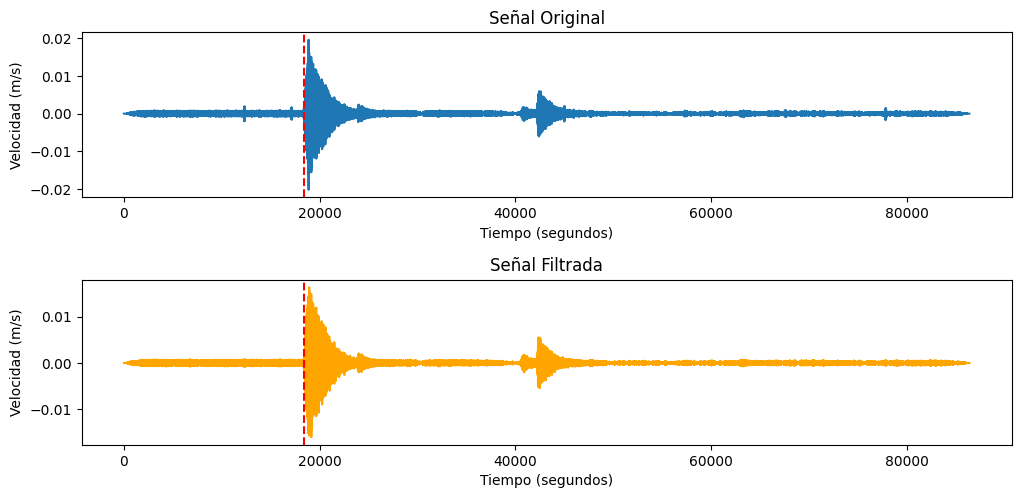

In [21]:
plt.figure(figsize=(12, 15))

# Subplot 1: Señal original
plt.subplot(5, 1, 1)
plt.plot(time, data, label="Señal original")
plt.title("Señal Original")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Velocidad (m/s)")
plt.axvline(arrival_time, color='r', linestyle='--')

# Subplot 2: Señal filtrada
plt.subplot(5, 1, 2)
plt.plot(time, data_filtered, label="Señal filtrada", color='orange')
plt.title("Señal Filtrada")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Velocidad (m/s)")
plt.axvline(arrival_time, color='r', linestyle='--')

# Ajustar los márgenes
plt.subplots_adjust(hspace=0.5)  # Aumenta el valor de hspace si es necesario


In [22]:
# Descomposición Empírica de Modo (EMD)
imfs = emd.sift.ensemble_sift(data_filtered, max_imfs=5)

Forma de imfs: (572411, 5)


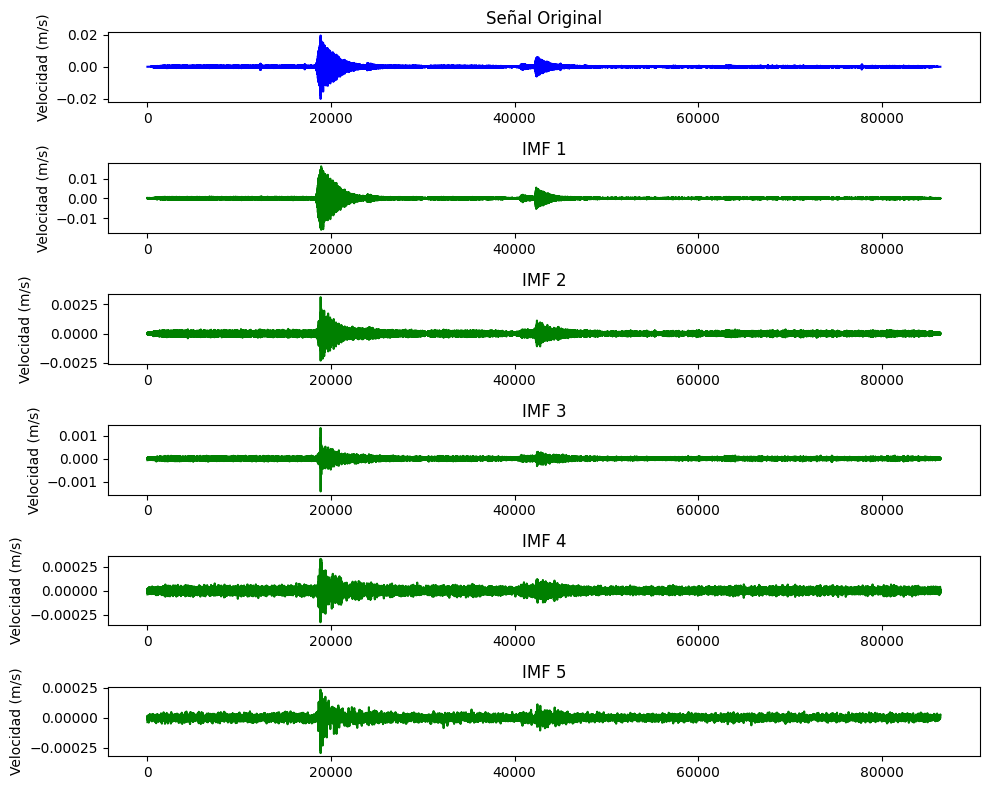

In [23]:
# Verificar la forma (dimensiones) de las IMFs
# Esto ayuda a entender cómo están organizadas las IMFs generadas
print("Forma de imfs:", imfs.shape)

# Crear una figura para graficar la señal original y las IMFs
# Se especifica el tamaño de la figura
plt.figure(figsize=(10, 8))

# Graficar la señal original
# La primera fila del gráfico se reserva para la señal original
plt.subplot(imfs.shape[1] + 1, 1, 1)  # `imfs.shape[1] + 1` asegura espacio para todas las IMFs más la señal original
plt.plot(time, data, 'b')  # Graficar la señal original con color azul ('b')
plt.title("Señal Original")  # Título del gráfico
plt.ylabel("Velocidad (m/s)")  # Etiqueta del eje y

# Graficar cada una de las IMFs
# Usamos `enumerate` para iterar sobre las IMFs y su índice
for i, imf in enumerate(imfs.T):  # `.T` transpone las IMFs para iterar por cada componente
    # Crear un subplot para cada IMF
    plt.subplot(imfs.shape[1] + 1, 1, i + 2)  # Reservar espacio para el IMF actual
    plt.plot(time, imf, 'g')  # Graficar el IMF actual en color verde ('g')
    plt.title(f"IMF {i + 1}")  # Título dinámico que indica el número del IMF
    plt.ylabel("Velocidad (m/s)")  # Etiqueta del eje y

# Ajustar los gráficos para que no se superpongan y se distribuyan correctamente
plt.tight_layout()

# Mostrar el gráfico
plt.show()


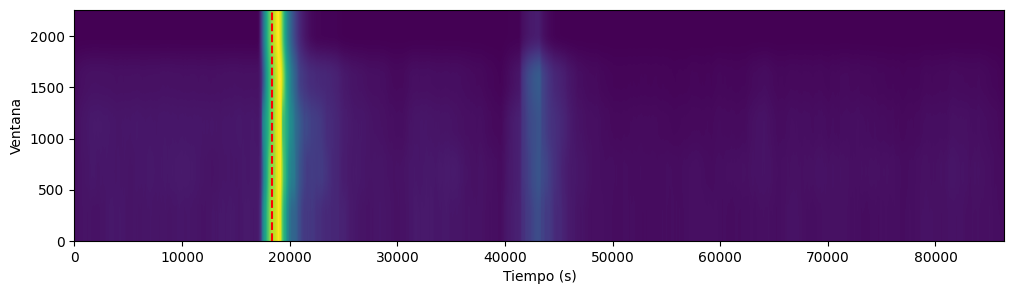

In [24]:
# Definimos el tamaño de la ventana en segundos
window_size_sec = 30 * 60  # 30 minutos

# Calculamos el tamaño de la ventana en muestras
# Esto se hace multiplicando la duración de la ventana en segundos por la frecuencia de muestreo (`fs`)
window_size = int(window_size_sec * fs)

# Calculamos el paso de la ventana, que determina cuántas muestras se mueven entre ventanas consecutivas
# En este caso, el paso es 1/48 del tamaño de la ventana (superposición entre ventanas)
window_step = window_size // 48

# Calculamos una vista deslizante de las IMFs elevadas al cuadrado
# `np.lib.stride_tricks.sliding_window_view` crea vistas de la señal con una ventana deslizante
# Cada ventana tiene el tamaño definido por `window_size` y se aplica sobre el eje 0 (tiempo)
energy = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::window_step, :, :]

# Calculamos la energía de cada ventana sumando sobre el último eje (dimensión de las IMFs)
energy = np.sum(energy, axis=-1)

# Normalizamos las energías
# Primero calculamos la energía máxima por cada IMF
maxEnergies = np.max(energy, axis=0)

# Dividimos cada ventana de energía entre el valor máximo correspondiente para normalizar
energy = energy / maxEnergies

# Configuración del gráfico
plt.subplots(1, 1, figsize=(12, 3))

# Graficamos las energías como una imagen (mapa de calor)
# `energy.T` transpone las energías para que se muestren correctamente
# `aspect='auto'` ajusta automáticamente la escala del eje x
# `extent` especifica los límites en tiempo (eje x) y ventanas (eje y)
plt.imshow(energy.T, aspect='auto', extent=[time[0], time[-1], 0, energy.shape[0]])

# Dibujamos una línea vertical en el tiempo de llegada (`arrival_time`) para marcarlo en el gráfico
plt.axvline(arrival_time, color='r', linestyle='--')

# Etiquetamos los ejes del gráfico
plt.xlabel('Tiempo (s)')
plt.ylabel('Ventana')

# Mostramos el gráfico
plt.show()


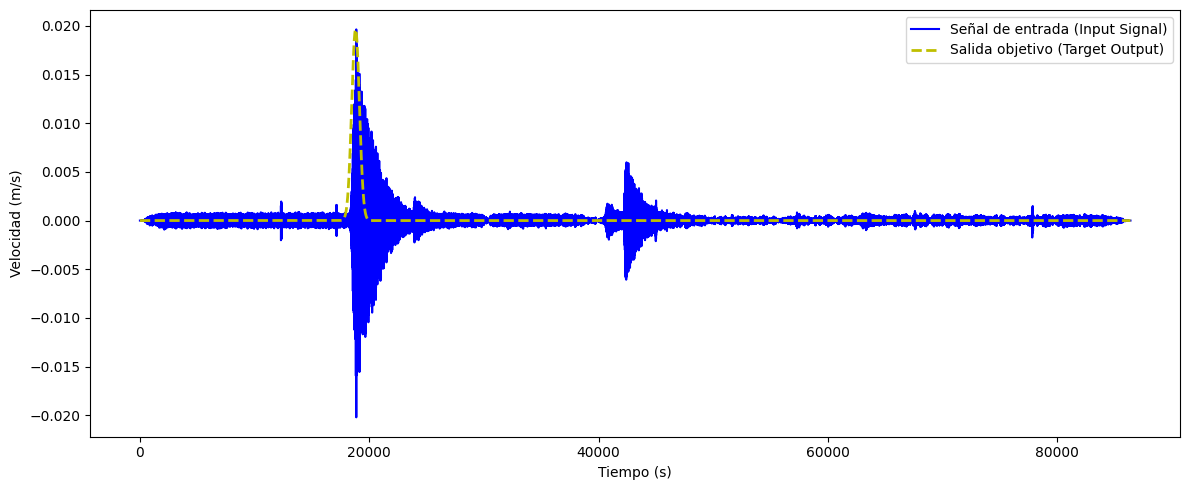

In [25]:
# Inicializamos un vector de salida del mismo tamaño que la señal original, lleno de ceros
output = np.zeros((data.shape[0], ))

# Calculamos el índice correspondiente al tiempo de llegada (`arrival_time`)
# Esto busca el primer índice en el arreglo `time` donde el valor cumple que es mayor o igual a `arrival_time`
# con un ajuste temporal basado en `window_size_sec / 4`.
arrival_idx = np.where(time - window_size_sec / 4 >= arrival_time)[0][0]

# Calculamos los parámetros de la ventana gaussiana
# `sigma` determina la desviación estándar de la campana gaussiana y está basada en el tamaño de la ventana.
sigma = window_size / 8 * 1.5

# Definimos el tamaño de la ventana gaussiana como 1.5 veces el tamaño de la ventana inicial.
gaussian_window_size = int(window_size * 1.5)

# Aseguramos que el tamaño de la ventana gaussiana sea par (esto es útil para mantener simetría).
if gaussian_window_size % 2 == 1:
    gaussian_window_size += 1

# Creamos la ventana gaussiana utilizando scipy.signal.windows.gaussian
# La función genera una curva de campana centrada con el tamaño y desviación estándar especificados.
gaussian_window = sg.windows.gaussian(gaussian_window_size, std=sigma)

# Calculamos los índices izquierdo y derecho donde la ventana gaussiana se ubicará en la señal.
left_idx = arrival_idx - (gaussian_window_size // 2)  # Índice izquierdo
right_idx = arrival_idx + (gaussian_window_size // 2)  # Índice derecho

# Ajustamos los índices para evitar desbordamiento (si los bordes caen fuera del rango de la señal)
if left_idx < 0:
    left_idx = 0  # Si el índice izquierdo es menor que 0, lo fijamos en 0
if right_idx > len(output):
    right_idx = len(output)  # Si el índice derecho excede el tamaño de la señal, lo fijamos en el máximo índice permitido

# Asignamos los valores de la ventana gaussiana dentro del rango calculado en el vector de salida.
# Si los límites están ajustados, usamos solo la parte correspondiente de la ventana gaussiana.
output[left_idx:right_idx] = gaussian_window[:right_idx - left_idx]

# Configuramos el gráfico
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Graficamos la señal original en color azul
ax.plot(time, data, 'b', label='Señal de entrada (Input Signal)')

# Graficamos la ventana gaussiana escalada con el valor máximo de la señal original en color amarillo discontinuo
ax.plot(time, output * data.max(), 'y--', label='Salida objetivo (Target Output)', linewidth=2)

# Dibujamos una línea vertical en el tiempo de llegada (`arrival_time`) para marcarlo en el gráfico
#ax.axvline(arrival_time, color='r', linestyle='--', linewidth=0.8)


# Etiquetamos los ejes
ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Velocidad (m/s)')

# Mostramos la leyenda para identificar las curvas
ax.legend()

# Ajustamos el diseño de la figura para que no haya sobreposición entre elementos
fig.tight_layout()


# Mostramos el gráfico
plt.show()


In [26]:
time - window_size_sec/4 >= arrival_time

array([False, False, False, ...,  True,  True,  True])

In [27]:
arrival_time

18360.0

In [28]:
arrival_idx

124617

In [29]:
np.where(time>=arrival_time)[0][0]

121635

In [30]:
tid = time[arrival_idx]